# Great crested newt eDNA metabarcoding data processing

I will use [metaBEAT](https://github.com/HullUni-bioinformatics/metaBEAT), a tool tailored towards reproducible and efficient analyses of metabarcoding data that was developed by Christoph Hahn (University of Graz) for the EvoHull group at University of Hull. The pipeline is still under active development and will likely be extended further in the future. The pipeline is available in a Docker container with all necessary dependencies. The Docker image builds on [ReproPhylo](https://github.com/HullUni-bioinformatics/ReproPhylo).

The data I will be analyzing are 12S rRNA sequences amplified from eDNA samples collected from ponds across the UK. The experiment was designed determine the sensitivity of eDNA metabarcoding for rare species, such as great crested newt, and assess the potential of eDNA metabarcoding to assess vertebrate community composition in freshwater ponds. 

The metaBEAT tool is designed for complete bioinformatic analysis from raw data, and performs (optionally) de-multiplexing, quality filtering, chimera detection, clustering, and taxononomic assignment (outputs in biom and tsv formats). It currently supports BLAST, Kraken and phylogenetic placement (pplacer). Further approaches will be included in the future to allow for efficient and standardized comparative assessments of all approaches. A large number of options are offered at each step of the pipeline to tailor bioinformatic analysis to different projects.

# Data input

This notebook will perform basic processing (trimming, merging, chimera removal) of the eDNA data. Clustering and taxonomic assignment will be performed in a separate notebook.

Minimum input for an analysis is a set of query sequences in one or several files (accepted are a number of file formats, e.g. fasta, fastq). These will be run through the pipeline sequentially.

Information on the nature and location of the query sequence files must be provided in a separate tab-delimited text file via the -Q flags.

Each line in this text file should look as follows: unique sample_ID, format, file1, file2

The required text files can be generated in any text editor. So theoretically, nano could be used in the terminal to construct the text file. For reproducibility and ease, a simple program can be used to generate the required file.

In the cell below, it is produced using a simple python script. The script will list all files in the location to which you've downloaded your Illumina data (specified via the 'datadir' variable). It assumes that there is a file ending in _R1.fastq for each sample. For each such file, it will extract the sample name from the filename and format the required line for the text file accordingly. The resulting file is called Querymap.txt (specified in the 'to' variable).

In [1]:
cd ..

/home/working/Harper_et_al_2018


In [2]:
!pwd

/home/working/Harper_et_al_2018


In [3]:
!mkdir 1-trimming

In [4]:
cd 1-trimming

/home/working/Harper_et_al_2018/1-trimming


In [5]:
!ls -1 ../raw_reads/

F100-12S_R1.fastq.gz
F100-12S_R2.fastq.gz
F101-12S_R1.fastq.gz
F101-12S_R2.fastq.gz
F10-12S_R1.fastq.gz
F10-12S_R2.fastq.gz
F102-12S_R1.fastq.gz
F102-12S_R2.fastq.gz
F103-12S_R1.fastq.gz
F103-12S_R2.fastq.gz
F104-12S_R1.fastq.gz
F104-12S_R2.fastq.gz
F105-12S_R1.fastq.gz
F105-12S_R2.fastq.gz
F106-12S_R1.fastq.gz
F106-12S_R2.fastq.gz
F107-12S_R1.fastq.gz
F107-12S_R2.fastq.gz
F108-12S_R1.fastq.gz
F108-12S_R2.fastq.gz
F109-12S_R1.fastq.gz
F109-12S_R2.fastq.gz
F110-12S_R1.fastq.gz
F110-12S_R2.fastq.gz
F111-12S_R1.fastq.gz
F111-12S_R2.fastq.gz
F11-12S_R1.fastq.gz
F11-12S_R2.fastq.gz
F112-12S_R1.fastq.gz
F112-12S_R2.fastq.gz
F1-12S_R1.fastq.gz
F1-12S_R2.fastq.gz
F113-12S_R1.fastq.gz
F113-12S_R2.fastq.gz
F114-12S_R1.fastq.gz
F114-12S_R2.fastq.gz
F115-12S_R1.fastq.gz
F115-12S_R2.fastq.gz
F116-12S_R1.fastq.gz
F116-12S_R2.fastq.gz
F117-12S_R1.fastq.gz
F117-12S_R2.fastq.gz
F118-12S_R1.fastq.gz
F118-12S_R2.fastq.gz
F119-12S_R1.fastq.gz
F119-12S_R2.fastq.gz
F120-12S_R1.fastq.gz
F120-12S_R2.fastq.gz


Prepare a text file specifying the samples to be processed including the format and location of the reads i.e. the querymap.

The next command expects two fastq files (forward and reverse reads) per sample in the directory ```../raw_reads/```. It expects the files to be named 'SampleID', followed by '_R1' or '_R2' to identify the forward/reverse read file respectively.

The raw data need to be downloaded with [this notebook](https://github.com/HullUni-bioinformatics/Harper_et_al_2018/blob/master/raw_reads/How_to_download_from_SRA.ipynb).

SampleID must correspond to the first column in the file Sample_accessions.tsv [(here)](https://github.com/HullUni-bioinformatics/Harper_et_al_2018/blob/master/Data/Sample_accessions.tsv). The marker is '12S'.

In [6]:
%%bash

for a in $(cat ../Data/Sample_accessions.tsv | grep "12S" | cut -f 1 | grep "SampleID" -v)
do
    R1=$(ls -1 ../raw_reads/$a-12S_* | grep "_R1.fastq")
    R2=$(ls -1 ../raw_reads/$a-12S_* | grep "_R2.fastq")

    echo -e "$a\tfastq\t$R1\t$R2"
done > Querymap.txt

In [7]:
!head -n 10 Querymap.txt

F1	fastq	../raw_reads/F1-12S_R1.fastq.gz	../raw_reads/F1-12S_R2.fastq.gz
F10	fastq	../raw_reads/F10-12S_R1.fastq.gz	../raw_reads/F10-12S_R2.fastq.gz
F100	fastq	../raw_reads/F100-12S_R1.fastq.gz	../raw_reads/F100-12S_R2.fastq.gz
F101	fastq	../raw_reads/F101-12S_R1.fastq.gz	../raw_reads/F101-12S_R2.fastq.gz
F102	fastq	../raw_reads/F102-12S_R1.fastq.gz	../raw_reads/F102-12S_R2.fastq.gz
F103	fastq	../raw_reads/F103-12S_R1.fastq.gz	../raw_reads/F103-12S_R2.fastq.gz
F104	fastq	../raw_reads/F104-12S_R1.fastq.gz	../raw_reads/F104-12S_R2.fastq.gz
F105	fastq	../raw_reads/F105-12S_R1.fastq.gz	../raw_reads/F105-12S_R2.fastq.gz
F106	fastq	../raw_reads/F106-12S_R1.fastq.gz	../raw_reads/F106-12S_R2.fastq.gz
F107	fastq	../raw_reads/F107-12S_R1.fastq.gz	../raw_reads/F107-12S_R2.fastq.gz


Add two columns to the text file containing the value 25 - this specifies the number of bases to be removed from the forward and reverse read.

In [8]:
%%bash

sed 's/$/&\t25/' Querymap.txt > Querymap_new.txt

In [9]:
!head -n 4 Querymap_new.txt

F1	fastq	../raw_reads/F1-12S_R1.fastq.gz	../raw_reads/F1-12S_R2.fastq.gz	25
F10	fastq	../raw_reads/F10-12S_R1.fastq.gz	../raw_reads/F10-12S_R2.fastq.gz	25
F100	fastq	../raw_reads/F100-12S_R1.fastq.gz	../raw_reads/F100-12S_R2.fastq.gz	25
F101	fastq	../raw_reads/F101-12S_R1.fastq.gz	../raw_reads/F101-12S_R2.fastq.gz	25


In [10]:
%%bash

sed 's/$/&\t25/' Querymap_new.txt > Querymap_final.txt

In [11]:
!head -n 4 Querymap_final.txt

F1	fastq	../raw_reads/F1-12S_R1.fastq.gz	../raw_reads/F1-12S_R2.fastq.gz	25	25
F10	fastq	../raw_reads/F10-12S_R1.fastq.gz	../raw_reads/F10-12S_R2.fastq.gz	25	25
F100	fastq	../raw_reads/F100-12S_R1.fastq.gz	../raw_reads/F100-12S_R2.fastq.gz	25	25
F101	fastq	../raw_reads/F101-12S_R1.fastq.gz	../raw_reads/F101-12S_R2.fastq.gz	25	25


# Raw read processing

Now, perform basic quality trimming and clipping (Trimmomatic) and paired-end read merging (flash). metaBEAT will be used to process all 768 samples in one go.

In [12]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>] [--bc_dist <INT>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--update_taxonomy] [--taxonomy_db <FILE>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adju

Command to trim:

In [13]:
%%bash

metaBEAT_global.py \
-Q Querymap_final.txt \
--trim_qual 30 --read_crop 110 --trim_minlength 90 \
--merge --forward_only --product_length 110 --length_filter 100 --length_deviation 0.2 \
-@ L.Harper@2015.hull.ac.uk \
-n 5 -v &> log 

Read processing will take several hours.


# Visualise query survival after trimming

metaBEAT will generate a directory with all temporary files that were created during the processing for each sample and will record useful stats summarizing the data processing in the file `metaBEAT_read_stats.csv`. You can explore the table manually or quickly plot out some of these stats here:

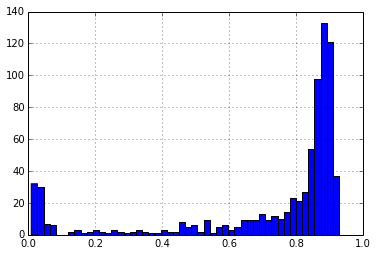

In [14]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('metaBEAT_read_stats.csv',index_col=0)
df['fraction'] = df['queries']/(df['total']*0.5)
df.fraction.hist(bins=50)

The final step in the processing will be global clustering of the centroids from all clusters from all samples to produce denovo OTUs. The temporary files from the global clustering and the final OTU table were written to the directory `./GLOBAL`.

In [15]:
!ls GLOBAL/

global_centroids.fasta	global.uc		  metaBEAT-OTU-denovo.tsv
global_queries.fasta	metaBEAT-OTU-denovo.biom


The denovo OTU table (numbers are reads) can be briefly to see how OTUs are distributed across your samples. 

Detailed information on what metaBEAT did to each sample is contained in the `log` file. It contains the exact commands that were run for each sample during each step of the process.

It's a large text file - look at the first 100 lines.

In [16]:
!head -n 100 log


metaBEAT - metaBarcoding and Environmental DNA Analyses tool
version: v.0.97.10-global


Sat Feb 17 18:04:27 2018

/usr/bin/metaBEAT_global.py -Q Querymap_final.txt --trim_qual 30 --read_crop 110 --trim_minlength 90 --merge --forward_only --product_length 110 --length_filter 100 --length_deviation 0.2 -@ L.Harper@2015.hull.ac.uk -n 5 -v


metaBEAT may be querying NCBI's Entrez databases to fetch/verify taxonomic ids. Entrez User requirements state that you need to identify yourself by providing an email address so that NCBI can contact you in case there is a problem.

You have specified: 'L.Harper@2015.hull.ac.uk'


Parsing querylist file

Number of samples to process: 760
Sequence input format: defaultdict(<type 'int'>, {'fastq': 760})
Barcodes for demultiplexing provided for 0 samples
Cropping instructions provided for 760 samples


Sat Feb 17 18:04:27 2018


##### processing query ID: F1 #####


### READ QUALITY TRIMMING ###


trimming PE reads with trimmomatic
java -jar /usr/bin/t

# Chimera detection

Some stats on the read counts before/after trimming, merging etc. are summarized for you in `read_stats.csv`.

Next stage of the processing is chimera detection and removal of putative chimeric sequences. We'll do that using uchime as implemented in vsearch.

In [2]:
!pwd

/home/working/Harper_et_al_2018/Jupyter notebooks


In [3]:
cd ../

/home/working/Harper_et_al_2018


In [4]:
!mkdir 2-chimera_detection

In [5]:
cd 2-chimera_detection

/home/working/Harper_et_al_2018/2-chimera_detection


Convert reference database from GenBank to fasta format to be used in chimera detection.

Prepare `REFmap.txt` file, i.e. text file that specifies the location and the format of the reference to be used.
The reference sequences in GenBank format are present in subdirectories for each vertebrate group in the `../Reference_database` directory.

In [6]:
!echo '../Reference_database/Amphibians/12S_UKamphibians_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Reptiles/12S_UKreptiles_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Mammals/12S_UKmammals_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Birds/12S_UKbirds_SATIVA_cleaned.gb\tgb\n' \
'../Reference_database/Fish/20161026_INBO_12S_fishrefs_hfj_edit.fasta\tfasta\n' \
'../Reference_database/Fish/custom_extended_12S_edit_10_2016.gb\tgb\n' \
'../Reference_database/Fish/RhamphochromisEsox_mt.gb\tgb' > REFmap.txt

In [7]:
!cat REFmap.txt

../Reference_database/Amphibians/12S_UKamphibians_SATIVA_cleaned.gb	gb
 ../Reference_database/Reptiles/12S_UKreptiles_SATIVA_cleaned.gb	gb
 ../Reference_database/Mammals/12S_UKmammals_SATIVA_cleaned.gb	gb
 ../Reference_database/Birds/12S_UKbirds_SATIVA_cleaned.gb	gb
 ../Reference_database/Fish/20161026_INBO_12S_fishrefs_hfj_edit.fasta	fasta
 ../Reference_database/Fish/custom_extended_12S_edit_10_2016.gb	gb
 ../Reference_database/Fish/RhamphochromisEsox_mt.gb	gb


In [8]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>] [--bc_dist <INT>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gb_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--update_taxonomy] [--taxonomy_db <FILE>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--bitscore_skim_LCA <FLOAT>] [--bitscore_skim_adju

In [9]:
%%bash

metaBEAT_global.py \
-R REFmap.txt \
-f \
-@ L.Harper@2015.hull.ac.uk


metaBEAT - metaBarcoding and Environmental DNA Analyses tool
version: v.0.97.10-global


Tue Feb 20 16:54:07 2018

/usr/bin/metaBEAT_global.py -R REFmap.txt -f -@ L.Harper@2015.hull.ac.uk


metaBEAT may be querying NCBI's Entrez databases to fetch/verify taxonomic ids. Entrez User requirements state that you need to identify yourself by providing an email address so that NCBI can contact you in case there is a problem.

You have specified: 'L.Harper@2015.hull.ac.uk'


######## PROCESSING REFERENCE DATA ########


processing ../Reference_database/Fish/RhamphochromisEsox_mt.gb (containing 1 records)

total number of valid records: 1


processing ../Reference_database/Mammals/12S_UKmammals_SATIVA_cleaned.gb (containing 1046 records)

total number of valid records: 1047


processing ../Reference_database/Fish/20161026_INBO_12S_fishrefs_hfj_edit.fasta (containing 85 records)

total number of valid records: 1132


processing ../Reference_database/Fish/custom_extended_12S_edit_10_2016.gb (co

Traceback (most recent call last):
  File "/usr/bin/metaBEAT_global.py", line 2499, in <module>
    out.write(BIOM_tables_per_method['OTU_denovo'].to_tsv()) #to_json('generaged by test', direct_io=out)
  File "/usr/local/lib/python2.7/dist-packages/biom/table.py", line 4027, in to_tsv
    observation_column_name)
  File "/usr/local/lib/python2.7/dist-packages/biom/table.py", line 1268, in delimited_self
    raise TableException("Cannot delimit self if I don't have data...")
biom.exception.TableException: Cannot delimit self if I don't have data...


This will produce `refs.fasta`.

In [10]:
!head refs.fasta

>NC_018563|163638|Rhamphochromis esox
GCTAGCGTAGCTTAACTAAAGCATAACACTGAAGATGTTAAGACGGTCCCTAGAAAGGTCCCGTGAGCACAAAGGCTTGGTCCTGACTTTACTGTCAACTTTGGCTAAACTTACACATGCAAGTCTCCGCCCCCCTGTGAGAATGCCCACAGTTTTCTGCCCGAAAACAAGGAGCTGGTATCAGGCACACTTTCCGCAGCCCATGACACCTTGCTTAGCCACACCCTCAAGGGAACTCAGCAGTGATAGACATTAAGCCATAAGTGAAAGCTTGACTTAGTTAAAGCCAAGAGGGCCGGTAAAACTCGTGCCAGCCACCGCGGTTATACGAGAGGCTCAAGTTGACAGACATCGGCGTAAAGGGTGGTTAGGAAGTTTTTAAACTAAAGCCGAACGCCCTCAGAACTGTTATACGTACCCGAGAGCAAGAAGCCCCACTACGAAAGTGGCTTTATATCCCCGACCCCACGAAAGCTGCGAAACAAACTGGGATTAGATACCCCACTATGCCCAGCCCTAAACCTTGATAGCCCCCTACACCCACTATCCGCCCGGGTACTACGAGCACTAGCTTAAAACCCAAAGGACTTGGCGGTGCTTTATATCCACCTAGAGGAGCCTGTTCTAGAACCGATAACCCCCGTTAAACCTCACCCCCTCTTGTTCTTCCCGTCTATATACCGCCGTCGTCAGCTTACCCTATGAAGGAACCACAGTAAGCAAAACTAGTACAACTCAAAACGCCAGGTCGAGGTGTAGCATATGAGGGGGGAAGAAATGAGCTACATTCCCTGCCACAGGGAATACGAACAATGTAATGAAATACACATTAGAAGGAGGATTTAGCAGTAAGCAGAAAATAGAGCGTTCCGCTGAAATTGGCCCTGAAGCGCGCACACACCGCCCGTCACTCTCCCCAAGCCAACAACATCCTATAAATAATATATTTTACCGGTAAAGGG

Now run chimera detection.

In [11]:
%%bash


for a in $(cut -f 1 ../1-trimming/Querymap.txt)
do
    if [ -s ../1-trimming/$a/$a\_trimmed.fasta ]
    then
        echo -e "\n### Detecting chimeras in $a ###\n"
        mkdir $a
        cd $a
        vsearch --uchime_ref ../../1-trimming/$a/$a\_trimmed.fasta --db ../refs.fasta \
        --nonchimeras $a-nonchimeras.fasta --chimeras $a-chimeras.fasta &> log 
        cd ..

    else
        echo -e "$a is empty"
    fi
done


### Detecting chimeras in F1 ###


### Detecting chimeras in F10 ###


### Detecting chimeras in F100 ###


### Detecting chimeras in F101 ###


### Detecting chimeras in F102 ###


### Detecting chimeras in F103 ###


### Detecting chimeras in F104 ###


### Detecting chimeras in F105 ###


### Detecting chimeras in F106 ###


### Detecting chimeras in F107 ###


### Detecting chimeras in F108 ###


### Detecting chimeras in F109 ###


### Detecting chimeras in F11 ###


### Detecting chimeras in F110 ###


### Detecting chimeras in F111 ###


### Detecting chimeras in F112 ###


### Detecting chimeras in F113 ###


### Detecting chimeras in F114 ###


### Detecting chimeras in F115 ###


### Detecting chimeras in F116 ###


### Detecting chimeras in F117 ###


### Detecting chimeras in F118 ###


### Detecting chimeras in F119 ###


### Detecting chimeras in F12 ###


### Detecting chimeras in F120 ###


### Detecting chimeras in F121 ###


### Detecting chimeras in F122 ###


### D